# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This notebook leverages the demo notebook from this repository: https://github.com/YuanGongND/ast

The notebook implements the benchmarking of pretrained Audio Spectrogram Transformer (AST) on the data set of humpback whales vocalizations.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```

## Step 1. Install and import required packages.

In [1]:
#%pip install timm==0.4.5
#%pip install wget
#%pip install librosa

In [2]:
#!git clone https://github.com/YuanGongND/ast

In [17]:
import sys
sys.path.append('./ast')

import os, csv, argparse, wget
os.environ['TORCH_HOME'] = 'ast/pretrained_models'
if os.path.exists('ast/pretrained_models') == False:
    os.mkdir('ast/pretrained_models')
if os.path.exists('ast/sample_audios') == False:
    os.mkdir('ast/sample_audios')

import librosa
import soundfile as sf
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

In [16]:
def list_folders(directory):
    folders = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_dir():
                folders.append(entry.name)
    return folders


def list_files(directory, extension):
    files = []
    for name in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, name)):
            if name.endswith(extension):
                files.append(name)
    return files

## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper.

In [65]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('ast/pretrained_models/audio_mdl.pth') == False:
    wget.download(audioset_mdl_url, out='ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = 'ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

# Load the AudioSet label set
label_csv = 'ast/egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: ast/pretrained_models/audio_mdl.pth


## Step 3. Load audio data and connect the sound class predictions

In [66]:
def resample_audio_file(audio_file_path):
    # Step 1: Load the WAV file and resample to 16kHz
    audio_data, original_sampling_rate = librosa.load(audio_file_path, sr=16000, res_type="soxr_vhq")

    # Step 2: Save the new WAV file with 16kHz sampling rate
    sf.write("ast/sample_audios/sample_audio_16kHz.wav", audio_data, 16000)
    
def predict(vocalization_type, audio_file_path):
    # Get a sample audio and make feature for predict
    feats = make_features('ast/sample_audios/sample_audio_16kHz.wav', mel_bins=128) # shape(1024, 128)
    feats_data = feats.expand(1, input_tdim, 128) # reshape the feature
    feats_data = feats_data.to(torch.device("cuda:0"))
    # do some masking of the input
    #feats_data[:, :512, :] = 0.

    # Make the prediction
    with torch.no_grad():
        with autocast():
            output = audio_model.forward(feats_data)
            output = torch.sigmoid(output)
    result_output = output.data.cpu().numpy()[0]
    sorted_indexes = np.argsort(result_output)[::-1]

    # Print audio tagging top probabilities
    predicted_labels = []
    predicted_scores = []
    for k in range(10):
        predicted_labels.append(np.array(labels)[sorted_indexes[k]])
        predicted_scores.append(result_output[sorted_indexes[k]])
    #print('Listen to this sample: ')
    #IPython.display.Audio('ast/sample_audios/sample_audio_16kHz.wav')
    
    return {"vocalization_type": vocalization_type, "audio_file": audio_file_path, "labels": predicted_labels, "scores": predicted_scores}

In [67]:
root = "./data/preprocessed"
vocalization_folders = list_folders(root)

results = []
errors = []
for vocalization_folder in vocalization_folders:
    audio_filenames = list_files(f"{root}/{vocalization_folder}", ".wav")
    print(f"Processing audio files in {root}/{vocalization_folder}")
    for audio_filename in audio_filenames:
        audio_file_path = f"{root}/{vocalization_folder}/{audio_filename}"
        resample_audio_file(audio_file_path)
        try:
            result = predict(vocalization_folder, audio_file_path)
            results.append(result)
        except Exception as e:
            print(e)
            errors.append(audio_file_path)

Processing audio files in ./data/preprocessed/Ascending_moan
Processing audio files in ./data/preprocessed/Bark
Processing audio files in ./data/preprocessed/Bellow
Processing audio files in ./data/preprocessed/Buzz
Processing audio files in ./data/preprocessed/Chirp
Processing audio files in ./data/preprocessed/Creak
Processing audio files in ./data/preprocessed/Cry
Processing audio files in ./data/preprocessed/Descending_moan
Processing audio files in ./data/preprocessed/Downsweep
Processing audio files in ./data/preprocessed/Growl
Processing audio files in ./data/preprocessed/Grunt
Processing audio files in ./data/preprocessed/Harmonica
Processing audio files in ./data/preprocessed/Knock
Processing audio files in ./data/preprocessed/Moan
Processing audio files in ./data/preprocessed/Piccalo
Processing audio files in ./data/preprocessed/Pop
choose a window size 400 that is [2, 378]
Processing audio files in ./data/preprocessed/Shriek
Processing audio files in ./data/preprocessed/Sigh

In [91]:
errors

['./data/preprocessed/Pop/OS_10_28_2021_18_54_00__311.wav']

In [68]:
results

[{'vocalization_type': 'Ascending_moan',
  'audio_file': './data/preprocessed/Ascending_moan/211026-133018-OS-humpback-47min-clip_10.wav',
  'labels': ['Raindrop',
   'Rain',
   'Rain on surface',
   'Animal',
   'Speech',
   'Domestic animals, pets',
   'Stream',
   'Gurgling',
   'Siren',
   'Waterfall'],
  'scores': [0.1934,
   0.1836,
   0.1687,
   0.0885,
   0.03897,
   0.03372,
   0.03108,
   0.02211,
   0.0205,
   0.0203]},
 {'vocalization_type': 'Ascending_moan',
  'audio_file': './data/preprocessed/Ascending_moan/211026-133018-OS-humpback-47min-clip_106.wav',
  'labels': ['Music',
   'Violin, fiddle',
   'Musical instrument',
   'Raindrop',
   'Rain',
   'Rain on surface',
   'Flute',
   'Speech',
   'Animal',
   'Bowed string instrument'],
  'scores': [0.4084,
   0.1941,
   0.1844,
   0.0891,
   0.05698,
   0.05194,
   0.05154,
   0.0354,
   0.02965,
   0.0263]},
 {'vocalization_type': 'Ascending_moan',
  'audio_file': './data/preprocessed/Ascending_moan/211026-133018-OS-hump

In [69]:
r = results

## Step 4. Plot the results

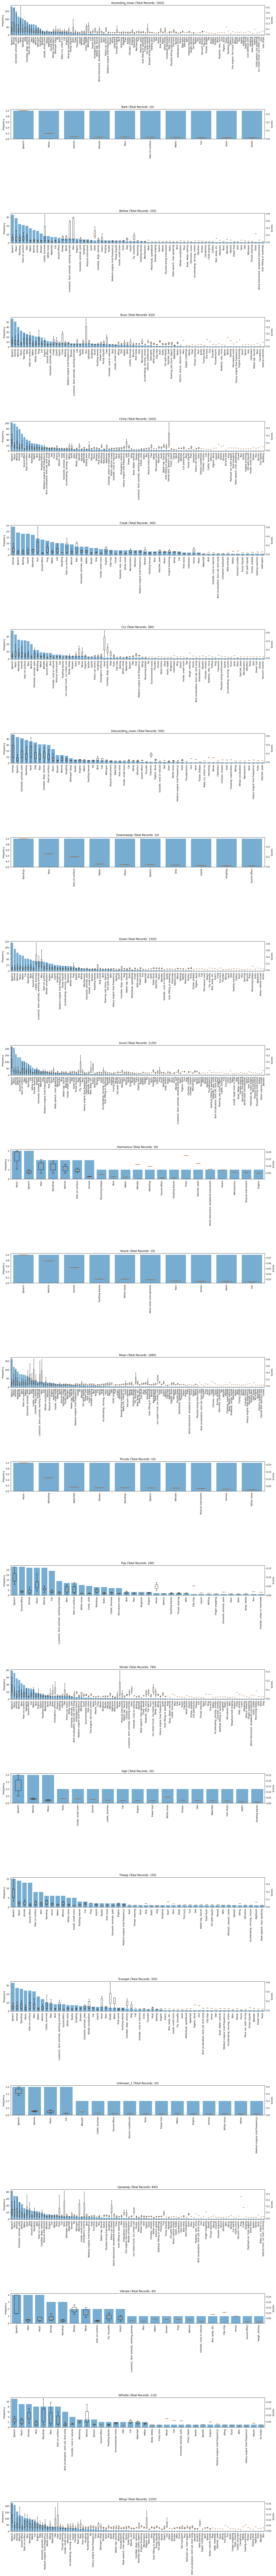

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter

# Organize data by vocalization_type
vocalization_data = defaultdict(list)
vocalization_scores = defaultdict(lambda: defaultdict(list))

for entry in results:
    vocal_type = entry["vocalization_type"]
    labels = entry["labels"]
    scores = entry["scores"]
    vocalization_data[vocal_type].extend(labels)
    
    for label, score in zip(labels, scores):
        vocalization_scores[vocal_type][label].append(score)

vocalization_count = {k: Counter(v) for k, v in vocalization_data.items()}

num_rows = len(vocalization_count)
fig, axs = plt.subplots(num_rows, 1, figsize=(20, 8 * num_rows))  # 1 plot per row

if num_rows == 1:
    axs = [axs]

for i, (vocal_type, count) in enumerate(vocalization_count.items()):
    labels, frequencies = zip(*sorted(count.items(), key=lambda x: x[1], reverse=True))  # Sort by frequency
    total_records = sum(frequencies)  # Sum of all frequencies for this vocalization type
    
    axs[i].bar(range(len(labels)), frequencies, alpha=0.6, label='Frequency')
    
    ax2 = axs[i].twinx()
    
    box_data = [vocalization_scores[vocal_type][label] for label in labels]
    ax2.boxplot(box_data, positions=range(len(labels)), vert=True, widths=0.4, showfliers=False)  # No outliers
    
    axs[i].set_xticks(range(len(labels)))  # Explicitly set x-tick locations
    axs[i].set_xticklabels(labels, rotation=90)  # Rotate x-axis labels
    
    axs[i].set_title(f"{vocal_type} (Total Records: {total_records})")  # Include total records in title
    axs[i].set_ylabel('Frequency')
    ax2.set_ylabel('Scores')

plt.subplots_adjust(hspace=2.5)
plt.show()